In [1]:
import dalmatian
import math
import numpy as np
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
print(matplt.__version__)
from scipy.stats import beta
from scipy.stats import binomtest
import statistics
import re
from datetime import datetime
TODAY=datetime.now().strftime("%d%b%Y")

3.8.0


In [2]:
file1 = '/Users/stewart/GoogleDrive/Lymphoma/2022/Classifier 2022 - Sept/Figures/signature analyzer/Update.22July2024/siignature_weighted.22July2024.maf'
M=pd.read_table(file1,skip_blank_lines=True,comment='#')
with pd.option_context('display.max_rows',30, 'display.max_columns', None, 'display.max_colwidth',50):
    display(M)

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,t_alt_count,t_ref_count,ref_context,GSM_NAME,context96.num,context96.word,XS1-Signature_17,XS2-Signature_1,XS3-Signature_19,clustered,sample,S1-SBS6,S2-SBS84,S3-SBS37
0,GLTPD1,NaN,NaN,37,1,1262649,1262649,+,Missense_Mutation,SNP,T,T,G,NaN,NaN,DFCIDL001_DT,NaN,NaN,NaN,ctc,DFCIDL001_DT,11,ACGG,5.019637e-02,0.949804,0.000000e+00,0,DFCIDL001_DT,0.919219,0.000003,8.077750e-02
1,NPHP4,NaN,NaN,37,1,5927131,5927131,+,Missense_Mutation,SNP,G,G,A,NaN,NaN,DFCIDL001_DT,NaN,NaN,NaN,cga,DFCIDL001_DT,95,CTTG,0.000000e+00,1.000000,0.000000e+00,0,DFCIDL001_DT,1.000000,0.000000,0.000000e+00
2,PHF13,NaN,NaN,37,1,6681577,6681577,+,Silent,SNP,G,G,A,NaN,NaN,DFCIDL001_DT,NaN,NaN,NaN,cga,DFCIDL001_DT,95,CTTG,0.000000e+00,1.000000,0.000000e+00,0,DFCIDL001_DT,1.000000,0.000000,0.000000e+00
3,VPS13D,NaN,NaN,37,1,12337823,12337823,+,Missense_Mutation,SNP,G,G,T,NaN,NaN,DFCIDL001_DT,NaN,NaN,NaN,ggg,DFCIDL001_DT,54,CACC,7.565879e-20,1.000000,2.923587e-37,0,DFCIDL001_DT,0.999788,0.000049,1.630591e-04
4,TINAGL1,NaN,NaN,37,1,32049107,32049107,+,Missense_Mutation,SNP,T,T,A,NaN,NaN,DFCIDL001_DT,NaN,NaN,NaN,atg,DFCIDL001_DT,40,ATCT,3.712904e-02,0.962871,3.853852e-37,0,DFCIDL001_DT,0.963333,0.000023,3.664409e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166279,ASB12,NaN,NaN,37,X,63444983,63444983,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,DLBC_FF_A7CX_TP_NB,NaN,59.0,6.0,gcc,DLBC_FF_A7CX_TP_NB,90,CTGC,0.000000e+00,1.000000,1.400000e-44,0,DLBC_FF_A7CX_TP_NB,0.999588,0.000412,0.000000e+00
166280,AWAT2,NaN,NaN,37,X,69261726,69261726,+,Missense_Mutation,SNP,G,G,A,NaN,NaN,DLBC_FF_A7CX_TP_NB,NaN,74.0,17.0,cgt,DLBC_FF_A7CX_TP_NB,83,CTAG,0.000000e+00,1.000000,0.000000e+00,0,DLBC_FF_A7CX_TP_NB,1.000000,0.000000,0.000000e+00
166281,SLC6A14,NaN,NaN,37,X,115584183,115584183,+,Splice_Site,SNP,T,T,A,NaN,NaN,DLBC_FF_A7CX_TP_NB,NaN,76.0,18.0,gtt,DLBC_FF_A7CX_TP_NB,34,ATAC,0.000000e+00,0.000000,1.000000e+00,0,DLBC_FF_A7CX_TP_NB,0.999805,0.000195,6.000000e-45
166282,DAB1,NaN,NaN,37,1,57480789,57480789,+,Missense_Mutation,SNP,T,T,G,NaN,NaN,DLBC_FF_A7CX_TP_NB_clustered,NaN,33.0,49.0,gtc,DLBC_FF_A7CX_TP_NB,10,ACGC,0.000000e+00,0.000000,1.000000e+00,1,DLBC_FF_A7CX_TP_NB_clustered,0.075032,0.000000,9.249679e-01


In [3]:
ID = list(set(M.GSM_NAME.to_list()))
len(ID)
S=pd.DataFrame(M.GSM_NAME.value_counts())
S.reset_index(inplace=True)
S.rename(columns={"GSM_NAME": "ID", "count": "Nmut"},inplace=True)
q=[M['S1-SBS6'].to_list(),M['S2-SBS84'].to_list(),M['S3-SBS37'].to_list()]
m = 1+np.argmax(q,axis=0)
M['sig']=m
S['Nage']=0
S['NcAID']=0
S['NAID2']=0
S['Nage_cluster']=0
S['NcAID_cluster']=0
S['NAID2_cluster']=0
for index1, row1 in S.iterrows():    
    M1 = M.loc[M['GSM_NAME']==row1['ID']]
    S.at[index1,'Nage']=M1.loc[M1['sig']==1].shape[0]
    S.at[index1,'NcAID']=M1.loc[M1['sig']==2].shape[0]
    S.at[index1,'NAID2']=M1.loc[M1['sig']==3].shape[0]
    S.at[index1,'Nage_cluster']=M1.loc[(M1['sig']==1)&(M1.clustered==1)].shape[0]
    S.at[index1,'NcAID_cluster']=M1.loc[(M1['sig']==2)&(M1.clustered==1)].shape[0]
    S.at[index1,'NAID2_cluster']=M1.loc[(M1['sig']==3)&(M1.clustered==1)].shape[0]

S

,ID,Nmut,Nage,NcAID,NAID2,Nage_cluster,NcAID_cluster,NAID2_cluster
0,DLBCL10837,1017,1009,4,4,22,4,0
1,DLBCL10544,1001,922,30,49,50,30,13
2,DLBCL11677,875,775,0,100,38,0,0
3,DLBCL10863,859,767,67,25,50,67,0
4,DLBCL10986,835,817,14,4,18,14,4
...,...,...,...,...,...,...,...,...
690,DLBCL_RICOVER_216,20,20,0,0,0,0,0
691,DLBCL11483,19,19,0,0,0,0,0
692,DLBCL_C_D_1140_NULLPAIR,15,15,0,0,0,0,0
693,DLBCL_DFCI_DLBCL_GOE07,8,8,0,0,0,0,0


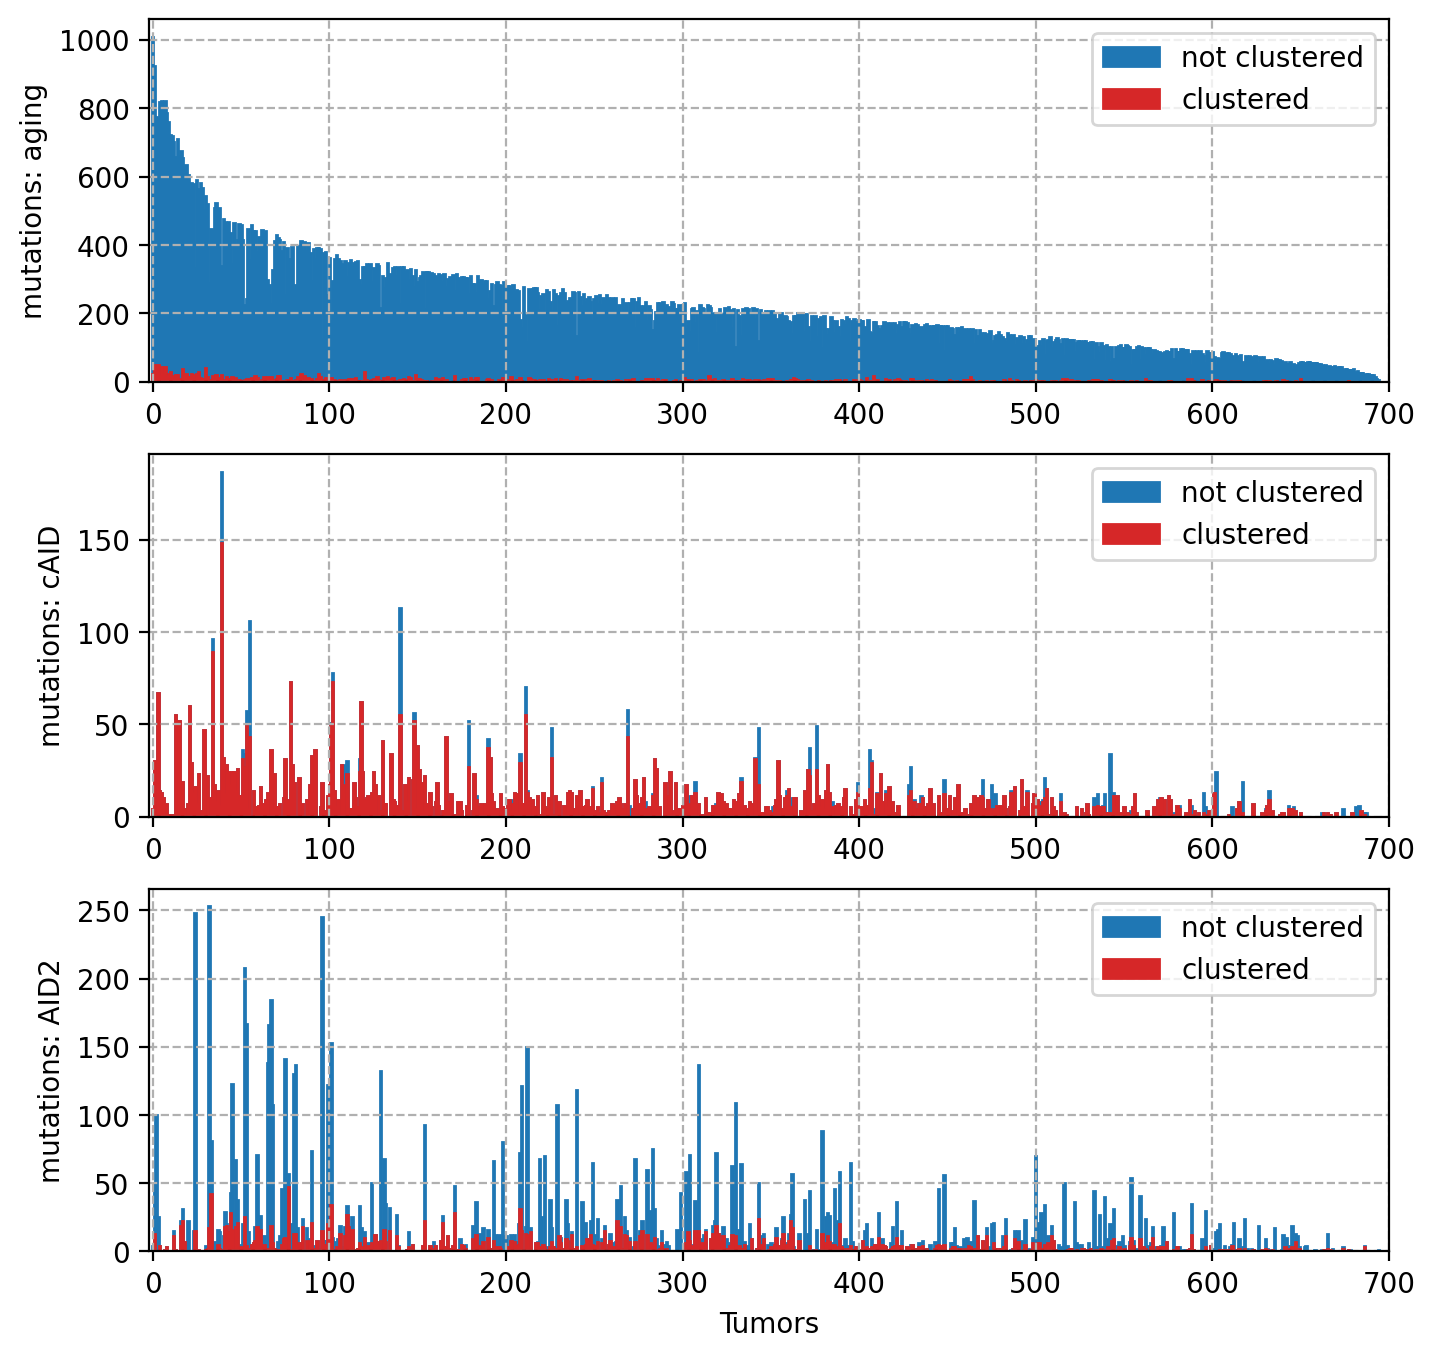

In [4]:
file2 = '/Users/stewart/GoogleDrive/Lymphoma/2022/Classifier 2022 - Sept/Figures/signature analyzer/Update.22July2024/signatures_tumor_bars.22July2024.fig_S14b.pdf'
pp = PdfPages(file2)

fig1, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1,  figsize =(8,8),dpi=200)

ax1.bar(S.index,S.Nage,label='not clustered',facecolor='tab:blue',edgecolor='tab:blue')
ax1.bar(S.index,S.Nage_cluster,label='clustered',facecolor='tab:red',edgecolor='tab:red')
ax1.set_xlabel('')
ax1.set_ylabel('mutations: aging')
ax1.grid('both',linestyle='--')
ax1.legend()
ax1.set_xlim([-2,700])

ax2.bar(S.index,S.NcAID,label='not clustered',facecolor='tab:blue',edgecolor='tab:blue')
ax2.bar(S.index,S.NcAID_cluster,label='clustered',facecolor='tab:red',edgecolor='tab:red')
ax2.set_xlabel('')
ax2.set_ylabel('mutations: cAID')
ax2.grid('both',linestyle='--')
ax2.legend()
ax2.set_xlim([-2,700])

ax3.bar(S.index,S.NAID2,label='not clustered',facecolor='tab:blue',edgecolor='tab:blue')
ax3.bar(S.index,S.NAID2_cluster,label='clustered',facecolor='tab:red',edgecolor='tab:red')
ax3.set_xlabel('Tumors')
ax3.set_ylabel('mutations: AID2')
ax3.grid('both',linestyle='--')
ax3.legend()
ax3.set_xlim([-2,700])

pp.savefig()
pp.close()

In [5]:
gsm_file = '/Users/stewart/GoogleDrive/Lymphoma/2022/Classifier 2022 - Sept/Data Tables/gsm/DLBCL.699.163drivers.Sep_23_2022.tsv'
GSM=pd.read_table(gsm_file,skip_blank_lines=True,comment='#')
GSM = GSM.loc[~(GSM['gene'].str.contains('SV.'))]
GSM = GSM.loc[~(GSM['gene'].str.contains('.DEL'))]
GSM = GSM.loc[~(GSM['gene'].str.contains('.AMP'))]
GSM = GSM[['gene']].reset_index(drop=True)
print(GSM.gene.to_list())
M1=M.loc[M['Hugo_Symbol'].isin(GSM.gene.to_list())]
GSM.shape,M.shape,M1.shape

['DTX1', 'CD70', 'TNFAIP3', 'NOTCH2', 'BCL10', 'B2M', 'CD58', 'FAS', 'UBE2A', 'ZEB2', 'BCL7A', 'TMEM30A', 'EBF1', 'GNAI2', 'NFKBIE', 'BCL6', 'SPEN', 'CXCR4', 'IKZF3', 'MYD88.OTHER', 'POU2F2', 'TUBGCP5', 'SMG7', 'CCDC27', 'FADD', 'RHOA', 'TNIP1', 'TP53', 'EP300', 'ZNF423', 'BCL2', 'CREBBP', 'TNFRSF14', 'EZH2', 'HVCN1', 'KMT2D', 'IRF8', 'GNA13', 'MAP2K1', 'SOCS1', 'PTEN', 'MEF2C', 'MEF2B', 'EEF1A1', 'POU2AF1', 'HIST1H1E', 'SGK1', 'DUSP2', 'LTB', 'KLHL6', 'ZFP36L1', 'HIST1H2BC', 'CD83', 'NFKBIA', 'TET2', 'BRAF', 'HIST1H1C', 'PTPN6', 'YY1', 'CRIP1', 'RAC2', 'HIST1H1B', 'HIST1H2AM', 'STAT3', 'HIST1H1D', 'ACTB', 'SESN3', 'PABPC1', 'KRAS', 'HIST1H2AC', 'CD274', 'METAP1D', 'PIM1', 'MYD88', 'BTG1', 'CD79B', 'MYD88.L265P', 'IGLL5', 'ETV6', 'TBL1XR1', 'BTG2', 'TMSB4X', 'PRDM1', 'GRHPR', 'HLA.B', 'CARD11', 'HLA.A', 'IRF2BP2', 'OSBPL10', 'TOX', 'HLA.C', 'PIM2', 'SF3B1', 'ZC3H12A', 'ATP2A2', 'BCL11A', 'IRF4', 'LYN', 'ETS1']


((99, 1), (166284, 32), (8063, 32))

In [6]:
G=pd.DataFrame(M1.Hugo_Symbol.value_counts())
G.reset_index(inplace=True)
G.rename(columns={"Hugo_Symbol": "gene", "count": "Nmut"},inplace=True)
q=[M1['S1-SBS6'].to_list(),M1['S2-SBS84'].to_list(),M1['S3-SBS37'].to_list()]
m = 1+np.argmax(q,axis=0)
M1['sig']=m
G['Nage']=0
G['NcAID']=0
G['NAID2']=0
G['Xage']=0.
G['Xage_low']=0.
G['Xage_high']=0.
G['XcAID']=0.
G['XcAID_low']=0.
G['XcAID_high']=0.
G['XAID2']=0.
G['XAID2_low']=0.
G['XAID2_high']=0.
#G['Nage_cluster']=0
#G['NcAID_cluster']=0
#G['NAID2_cluster']=0
for index1, row1 in G.iterrows():    
    M2 = M1.loc[M1['Hugo_Symbol']==row1['gene']]
    G.at[index1,'Nage']=M2.loc[M2['sig']==1].shape[0]
    G.at[index1,'NcAID']=M2.loc[M2['sig']==2].shape[0]
    G.at[index1,'NAID2']=M2.loc[M2['sig']==3].shape[0]
    #G.at[index1,'Nage_cluster']=M2.loc[(M2['sig']==1)&(M2.clustered==1)].shape[0]
    #G.at[index1,'NcAID_cluster']=M2.loc[(M2['sig']==2)&(M2.clustered==1)].shape[0]
    #G.at[index1,'NAID2_cluster']=M2.loc[(M2['sig']==3)&(M2.clustered==1)].shape[0]
    xlo,xhi=binomtest( G.at[index1,'Nage'], G.at[index1,'Nmut']).proportion_ci(confidence_level=0.68) # 1-sigma CI's
    G.at[index1,'Xage_low']=xlo
    G.at[index1,'Xage_high']=xhi
    xlo,xhi=binomtest( G.at[index1,'NcAID'], G.at[index1,'Nmut']).proportion_ci(confidence_level=0.68)
    G.at[index1,'XcAID_low']=xlo
    G.at[index1,'XcAID_high']=xhi
    xlo,xhi=binomtest( G.at[index1,'NAID2'], G.at[index1,'Nmut']).proportion_ci(confidence_level=0.68)
    G.at[index1,'XAID2_low']=xlo
    G.at[index1,'XAID2_high']=xhi
    
G['Xage']=G['Nage']/G['Nmut']
G['XcAID']=G['NcAID']/G['Nmut']
G['XAID2']=G['NAID2']/G['Nmut']

G=G.loc[G.Nmut>10].reset_index(drop=True) 
G=G.sort_values(by=['Xage','XcAID'],ignore_index=True,ascending=False).copy()
with pd.option_context('display.max_rows',None, 'display.max_columns', None, 'display.max_colwidth',50):
    display(G)

/var/folders/zr/cfx1dgsx5xx60l9xj91_yw480000gp/T/ipykernel_12778/291121571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M1['sig']=m


,gene,Nmut,Nage,NcAID,NAID2,Xage,Xage_low,Xage_high,XcAID,XcAID_low,XcAID_high,XAID2,XAID2_low,XAID2_high
0,NOTCH2,45,45,0,0,1.000000,0.960094,1.000000,0.000000,0.000000,0.039906,0.000000,0.000000,0.039906
1,SPEN,67,65,0,2,0.970149,0.932313,0.989349,0.000000,0.000000,0.026981,0.029851,0.010651,0.067687
2,MYD88,165,158,3,4,0.957576,0.935583,0.973026,0.018182,0.008337,0.035466,0.024242,0.012719,0.042903
3,ZNF423,23,22,0,1,0.956522,0.863957,0.992448,0.000000,0.000000,0.076586,0.043478,0.007552,0.136043
4,RAC2,21,20,0,1,0.952381,0.851704,0.991732,0.000000,0.000000,0.083567,0.047619,0.008268,0.148296
5,SF3B1,19,18,0,1,0.947368,0.837031,0.990865,0.000000,0.000000,0.091946,0.052632,0.009135,0.162969
6,FAS,54,51,1,2,0.944444,0.893590,0.974424,0.018519,0.003224,0.059622,0.037037,0.013222,0.083585
7,TUBGCP5,45,42,0,3,0.933333,0.873003,0.969272,0.000000,0.000000,0.039906,0.066667,0.030728,0.126997
8,KMT2D,209,195,1,13,0.933014,0.911064,0.950296,0.004785,0.000834,0.015649,0.062201,0.045533,0.083610
9,ZC3H12A,28,26,2,0,0.928571,0.842430,0.974435,0.071429,0.025565,0.157570,0.000000,0.000000,0.063354


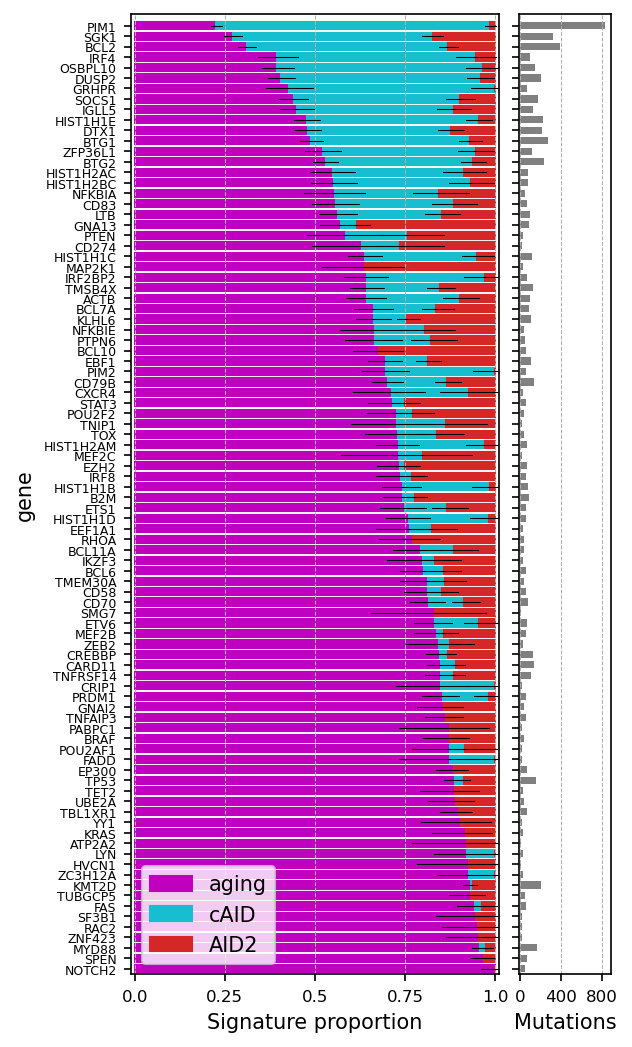

In [7]:
pdffile = '/Users/stewart/GoogleDrive/Lymphoma/2022/Classifier 2022 - Sept/Figures/signature analyzer/Update.22July2024/signatures_gene_bars.22July2024.fig_S14c.pdf'
pp = PdfPages(file2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,  figsize =(4,8),dpi=150, sharey=True, gridspec_kw={'width_ratios': [4, 1]})
fig.tight_layout(pad=-0.01)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

#fig1, ax1 = plt.subplots(nrows=1, ncols=1,  figsize =(4,8),dpi=200)

ax1.barh(G.index,G.Xage,left=0,label='aging',facecolor='m',edgecolor='m',height=0.68)
ax1.plot([G.Xage_low,G.Xage_high],[G.index, G.index],color='k',linewidth=0.5)
x0 = G.Xage
ax1.barh(G.index,G.XcAID,left=x0,label='cAID',facecolor='tab:cyan',edgecolor='tab:cyan',height=0.68)
ax1.plot([G.XcAID_low+x0,G.XcAID_high+x0],[G.index, G.index],color='k',linewidth=0.5)
x0 = G.Xage+G.XcAID
ax1.barh(G.index,G.XAID2,left=x0,label='AID2',facecolor='tab:red',edgecolor='tab:red',height=0.68)
ax1.set_xlabel('')
ax1.set_ylabel('gene')
#
ax1.legend()
ax1.set_ylim([-0.5,G.shape[0]+0.1])
ax1.set_yticks(G.index)
ax1.set_xticks(np.linspace(0,1,5))
ax1.set_xticklabels([str(float(x)) for x in np.linspace(0,1,5)],fontsize=8)
ax1.set_yticklabels(G.gene,fontsize=6)
ax1.xaxis.grid(linestyle='--',linewidth=0.5)
ax1.set_xlabel('Signature proportion')
ax1.set_xlim([-0.01,1.01])

ax2.barh(G.index,G.Nmut,left=0,color='grey',height=0.68)
ax2.xaxis.grid(linestyle='--',linewidth=0.5)
ax2.set_xticks(np.linspace(0,800,3))
ax2.set_xticklabels([int(x) for x in np.linspace(0,800,3)],fontsize=8)
ax2.set_xlabel('Mutations')
ax2.set_xlim([-5.0,890.0])


pp.savefig(bbox_inches='tight')
pp.close()


In [ ]:
[str(float(x)) for x in np.linspace(0,1,5)]